In [2]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import matplotlib.pyplot as plt
import time
import cv2
import math
from PIL import Image
plt.rcParams['figure.figsize'] = 15, 10

# 检测文字图片的倾斜并纠正

((138.4099578857422, 170.21556091308594), (169.0591278076172, 256.2396240234375))


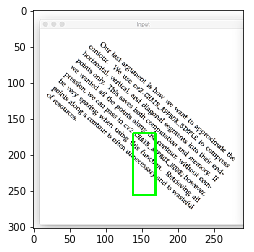

((138.4099578857422, 170.21556091308594), (169.0591278076172, 256.2396240234375), -40.76360321044922)


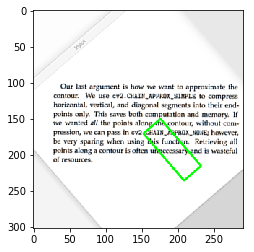

In [4]:
# https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
import numpy as np
import cv2
image = cv2.imread('d:\\text_skew.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
 
# threshold the image, setting all foreground pixels to
# 255 and all background pixels to 0
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
rect = cv2.minAreaRect(coords)[0:2]
print(rect)
x1,y1 = rect[0]
x2,y2 = rect[1]
x1 = int(x1)
x2=int(x2)
y1=int(y1)
y2=int(y2)
cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(image,'gray')
plt.show()
print(cv2.minAreaRect(coords))

if angle < -45:
    angle = -(90 + angle)
 
# otherwise, just take the inverse of the angle to make
# it positive
else:
    angle = -angle
    
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)    

plt.imshow(rotated,'gray')
plt.show()

# 处理填空题

In [2]:
# https://www.cnblogs.com/korbin/p/5625340.html
import math
DEBUG = True
img = cv2.imread('d:\\fill2.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)

plt.imshow(img,'gray')
plt.show()

cols = img.shape[1]
horizontal_size = int(cols / 40)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
img = cv2.erode(img, horizontalStructure)
img = cv2.dilate(img, horizontalStructure)

img = cv2.blur(img, tuple((3, 3)))
element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((5, 5)), (-1, -1))
img = cv2.dilate(img, element, iterations=1)

plt.imshow(img,'gray')
plt.show()


# 扫线最小长度取图片的宽 20%长度
minLineLength = int(img.shape[1] * 0.3)
lines = cv2.HoughLinesP(img, 1, np.pi / 180, 20, minLineLength=minLineLength, maxLineGap=30)


imgcanv = Image.new("RGB", (img.shape[1], img.shape[0]), (255, 255, 255))
imgcanv = np.array(imgcanv)
lines = lines[:,0,:]
exmr = []
for line in lines:
    x1, y1, x2, y2 = line
    width = abs(x2-x1)
    hight = abs(y2-y1)
    x1,y1,width,hight = int(10*round(x1/10)), int(10*round(y1/10)), int(10*round(width/10)), int(10*round(hight/10))
    if int(100 * width/img.shape[1]) <= 30 and int(100 * width/img.shape[1]) >= 20:
        # 进行四舍五入操作,为后期排重做准备
        exmr.append([x1,y1,width,hight,int(100 * width/img.shape[1])])
        
exmr = np.array(exmr)
print(len(exmr))
# 根据Y轴进行排重
va,inx = np.unique(exmr[:,1] + exmr[:,0],return_index=True)
exmr = exmr[inx]

# exmr = exmr[exmr[:,2]>200]
idex = np.lexsort([exmr[:, 0], exmr[:, 1]])


exmr = exmr[idex,:]
# cidx = [0,3,4,6,9,10,11,14,16,18,20]
# exmr = exmr[cidx,:]

# print(exmr)
if DEBUG:
    for item in exmr:
        x1,y1,w,h,s = item
        cv2.line(imgcanv, (x1, y1), (x1+w, y1+h), (120, 120, 120), 2)
        
if DEBUG:
#     logger.debug('调试，显示划线图')
    plt.imshow(imgcanv,'gray')
    plt.show()

print(exmr)
# plt.imshow(img,'gray')
# plt.show()
# print(exmr)

error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [11]:

# 根据Y轴取维一的值 
# print(exmr)
v = np.unique(exmr[:,1])
print(v[1:])
# 去掉Y轴相近的值，得到分组的基本值
vv = [x for i,x in enumerate(v[1:]) if abs(x-v[i])> 10 ]
vv.insert(0,v[0])
print(vv)
# 根据分组的基本值，得到相应的索引位值,  再对比X轴的值，去掉相近的值
groups = []
for item in vv:
    idx =np.where(abs(exmr[:,1]-item) <= 10)[0]
    if(len(idx)>1):
        # 因为X轴已按从小到大排序，所以可以利用其特点按序进行检测
        xidxs = [idx[0]]
#         current = idx[0]
        for xitem in idx[1:]:
            
            if np.all(abs(exmr[xidxs,0] - exmr[xitem,0]) > 20):
                xidxs.append(xitem)
                current = xitem
        
        groups.append([item,xidxs])
    else:
        groups.append([item,idx.tolist()])

print(groups)

gp = [x[1] for x in groups]
print(gp)
cc = np.array(gp)
# print(cc.reshape(-1))
# cidx = [0,3,4,6,9,10,11,14,16,18,20]
# print(exmr)
# print(exmr[cidx])



[ 30 170 180 190 240 250 260 310 320 330 340 390 400 410 460 470 480]
[10, 30, 170, 240, 310, 390, 460]
[[10, [0]], [30, [1, 2, 4, 5, 6, 7]], [170, [8, 11]], [240, [20, 22]], [310, [30, 32, 33, 35]], [390, [38]], [460, [47, 48, 49, 51, 53]]]
[[0], [1, 2, 4, 5, 6, 7], [8, 11], [20, 22], [30, 32, 33, 35], [38], [47, 48, 49, 51, 53]]


In [ ]:
Debug = True

def clip_exam(self):
    if DEBUG:
        logger.debug('中心区域图片')
        plt.imshow(self.center_gray_img,'gray')
        plt.show()

    image = np.copy(self.center_gray_img)
    img = cv2.GaussianBlur(image, (5, 5), 0)
    # ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    if DEBUG:
        logger.debug('调试，显示图片二进制图')
        plt.imshow(bw,'gray')
        plt.show()

    horizontal = np.copy(bw)

    cols = horizontal.shape[1]
    horizontal_size = int(cols / 30)

    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
    horizontal = cv2.erode(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)

    regions = self._get_rect(horizontal)
    return regions

def _get_rect(image):

    # 线加组
    image = cv2.blur(image, tuple((5, 5)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 21)), (-1, -1))
    imgr = cv2.dilate(image, element, iterations=1)
    if DEBUG:
        #             logger.debug('调试，显示处理后合并图')
        plt.imshow(imgr, 'gray')
        plt.show()

    nimg, contours, hierarchy = cv2.findContours(imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cnts.append([y, x,  h ,w])
    cnts = np.array(cnts)
    idex = np.lexsort([cnts[:, 1], cnts[:, 0]])
    cnts = cnts[idex,:].tolist()


    answer_lines = []
    for cnt in cnts:
        if (cnt[3] > int(self.center_width*0.2)) and (cnt[3] < int(self.center_width * 0.9)):
            answer_lines.append([cnt[0]+self.center_y, cnt[1] + self.center_x, cnt[2], cnt[3]])
    # print(self.answer_lines)

    cnts = [x for x in cnts if x[3] >= int(self.center_width*0.9)]

    regions = []
    for i in range(len(cnts) - 1):
        regions.append([cnts[i][0] + self.center_y, cnts[i][1] + self.center_x, cnts[i+1][0] - cnts[i][0], cnts[i][3]])

    # print(regions)
    return  regions, answer_lines


# 处理填空题方式二（当前真实采用的)

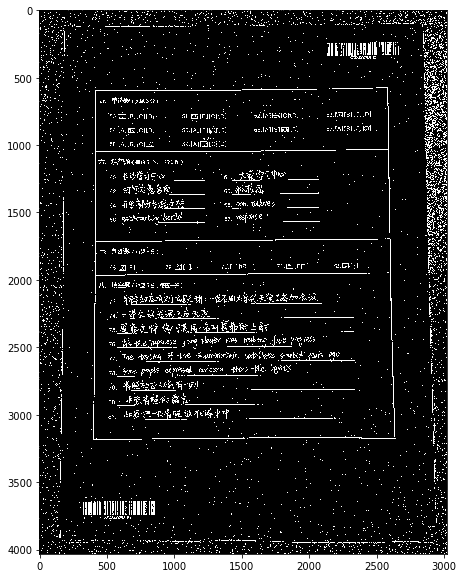

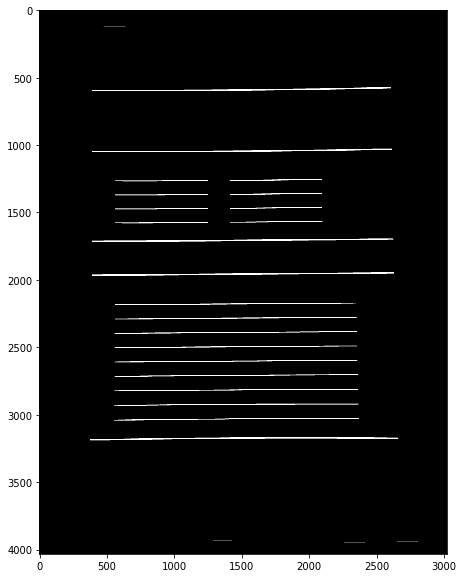

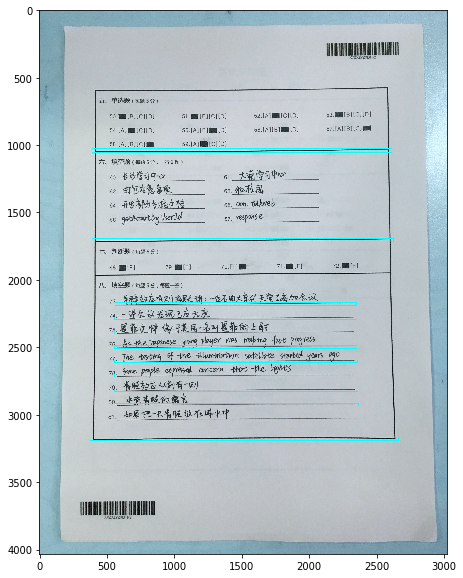

In [5]:
DEBUG = True
# 试卷题目边框将试卷分割
def clip_exam(center_gray_img):
#     if DEBUG:
#         plt.imshow(center_gray_img,'gray')
#         plt.show()

    image = np.copy(center_gray_img)
    img = cv2.GaussianBlur(image, (5, 5), 0)
    # ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    bw = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 2)

    if DEBUG:
        plt.imshow(bw,'gray')
        plt.show()

    horizontal = np.copy(bw)

    cols = horizontal.shape[1]
    horizontal_size = int(cols / 30)

    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
    horizontal = cv2.erode(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)

    regions,answer_lines = _get_rect(horizontal,image.shape[0])
    return regions,answer_lines

def _get_rect(image,center_width, center_x=0,center_y=0):

    # 线加组
    image = cv2.blur(image, tuple((3, 3)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 3)), (-1, -1))
    imgr = cv2.dilate(image, element, iterations=2)
    if DEBUG:
        #     logger.debug('调试，显示处理后合并图')
        plt.imshow(imgr, 'gray')
        plt.show()

    nimg, contours, hierarchy = cv2.findContours(imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cnts.append([y, x,  h ,w])
    cnts = np.array(cnts)
    idex = np.lexsort([cnts[:, 1], cnts[:, 0]])
    cnts = cnts[idex,:].tolist()


    answer_lines = []
    for cnt in cnts:
        if (cnt[3] > int(center_width*0.2)) and (cnt[3] < int(center_width * 0.9)):
            answer_lines.append([cnt[0]+center_y, cnt[1] + center_x, cnt[2], cnt[3]])
    # print(self.answer_lines)
    
#     print(answer_lines)

    cnts = [x for x in cnts if x[3] >= int(center_width*0.9)]

    regions = []
    for i in range(len(cnts) - 1):
        regions.append([cnts[i][0] + center_y, cnts[i][1] + center_x, cnts[i+1][0] - cnts[i][0], cnts[i][3]])

    # print(regions)
    return  regions,answer_lines
new_img = cv2.imread('d:\\center.png')
center_img = cv2.imread('d:\\center.png',cv2.IMREAD_GRAYSCALE)
region ,answer_lines = clip_exam(center_img)
for rect in answer_lines:
    y,x,h,w = rect
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,255),2)
cv2.imwrite('d:\\result.jpg',new_img)
plt.imshow(new_img,'brg')
plt.show()


In [28]:
aa = np.array(answer_lines)
idx = np.lexsort([aa[:,1],aa[:,0]])
aa = aa[idx]
print(aa.tolist())

[[0, 0, 39, 1759], [447, 0, 41, 1754], [895, 3, 40, 1753], [1176, 4, 41, 1756], [1347, 953, 30, 729], [1352, 139, 32, 729], [1430, 953, 30, 729], [1435, 140, 32, 729], [1513, 954, 30, 730], [1518, 140, 33, 730], [1596, 951, 30, 739], [1602, 140, 32, 731], [1679, 956, 31, 731], [1686, 140, 31, 731], [1762, 957, 33, 731], [1771, 140, 30, 732], [1846, 958, 34, 731], [1856, 140, 30, 732], [1930, 959, 35, 731], [1941, 139, 31, 734], [1989, 960, 61, 731], [2026, 139, 31, 735], [2163, 1, 45, 1764]]


# 识别试卷中心区域

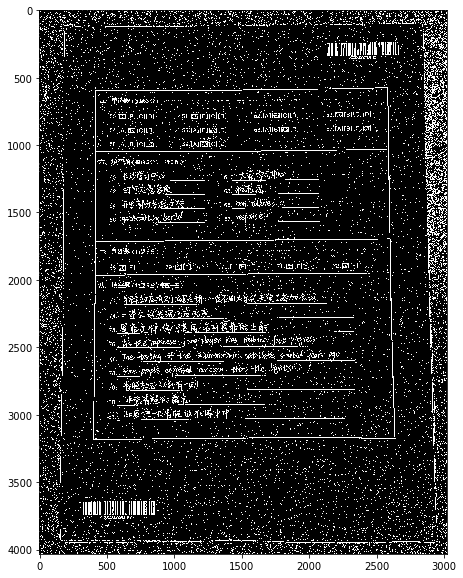

79754
[5696709.5, 2669246.0, 533257.5, 1428464.5, 969127.0]


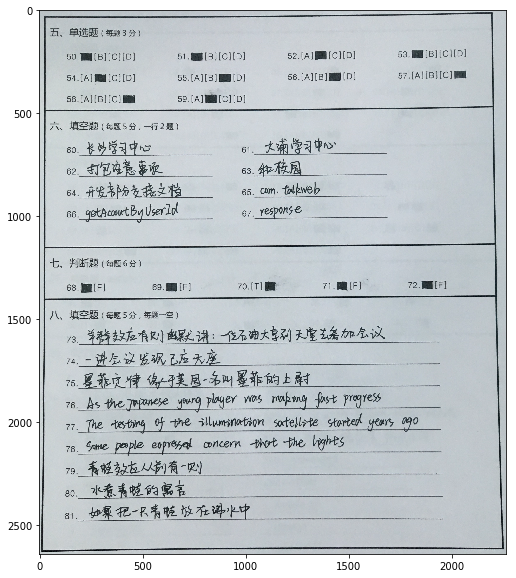

In [6]:
# https://blog.csdn.net/keith_bb/article/details/53470170?utm_source=blogxgwz0  华为荣耀V10 小米max1
path = 'D:/center.png'
imgage = cv2.imread(path,cv2.IMREAD_COLOR)
# print(imgage)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
# img = cv2.blur(img,tuple((5,5)))
plt.imshow(img,'gray')
plt.show()
nimg, contours, hierarchy = cv2.findContours(
    img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
rcnt = []
rarea = []
for cnt in contours:
    if cv2.contourArea(cnt) > 40000:
        rarea.append(cv2.contourArea(cnt))
        rcnt.append(cnt)
print(rarea)        
pos = np.argmax(rarea)        
cnt = rcnt[pos]
x,y,w,h = cv2.boundingRect(cnt)
# cv2.rectangle(imgage,(x,y),(x+w,y+h),0,-1)
# plt.imshow(imgage,'brg')
# plt.show()
x = x-10
w = w + 20
y = y - 10
h = h + 20
crop_img = imgage[y:y+h, x:x+w]
cv2.imwrite('d:/crop.jpg',crop_img)
plt.imshow(crop_img,'brg')
plt.show()

# 识别试卷边框

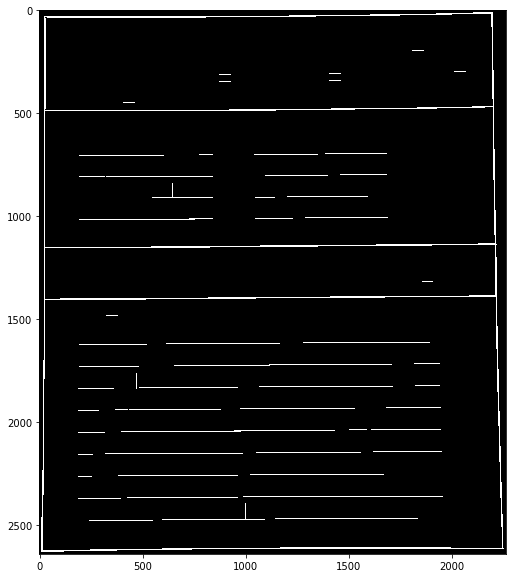

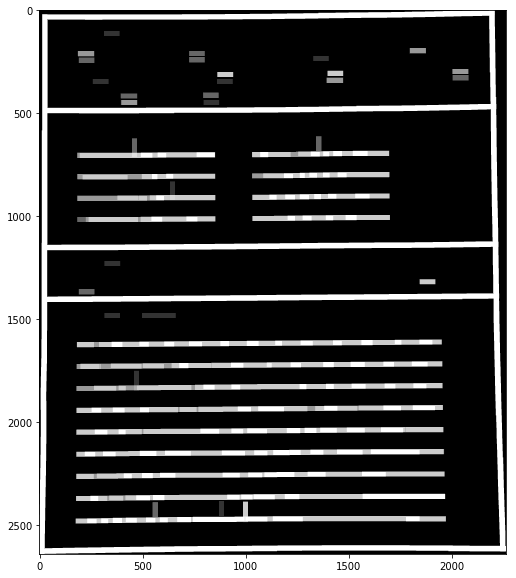

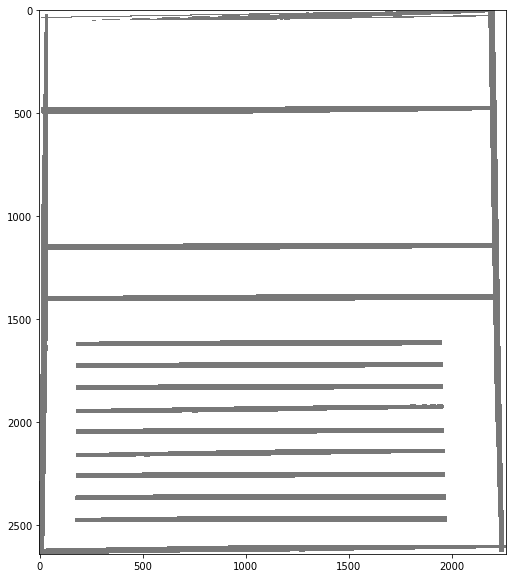

In [7]:
DEBUG = True

def _get_rect(image):
        image = cv2.blur(image, tuple((5, 5)))
        element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 21)), (-1, -1))
        imgr = cv2.dilate(image, element, iterations=1)
        if DEBUG:
#             logger.debug('调试，显示处理后合并图')
            plt.imshow(imgr,'gray')
            plt.show()

        lines = cv2.HoughLinesP(imgr, 1, np.pi / 180, 20, minLineLength=1000, maxLineGap=80)
        if DEBUG:
            imgt = Image.new("RGB", (imgr.shape[1], imgr.shape[0]), (255, 255, 255))
            imgt = np.array(imgt)
        lines = lines[:,0,:]
        exmr = []
        for line in lines:
            x1, y1, x2, y2 = line
            if DEBUG:
                cv2.line(imgt, (x1, y1), (x2, y2), (120, 120, 120), 2)
            width = abs(x2-x1)
            hight = abs(y2-y1)
            exmr.append([x1,y1,width,hight, sum((x1,y1,hight,width))])

        if DEBUG:
#             logger.debug('调试，显示划线图')
            plt.imshow(imgt,'gray')
            plt.show()

    



imgage = cv2.imread('d:/crop.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)  # 11, 2 这两个参数有什么用 ？？

horizontal = np.copy(img)
vertical = np.copy(img)

cols = horizontal.shape[1]
horizontal_size = int(cols / 40)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

rows = vertical.shape[0]
verticalsize = int(rows / 40)
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))

# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

nn = cv2.bitwise_or(vertical,horizontal)
plt.imshow(nn,'gray')
plt.show()

_get_rect(nn)


# 识别试卷边框二

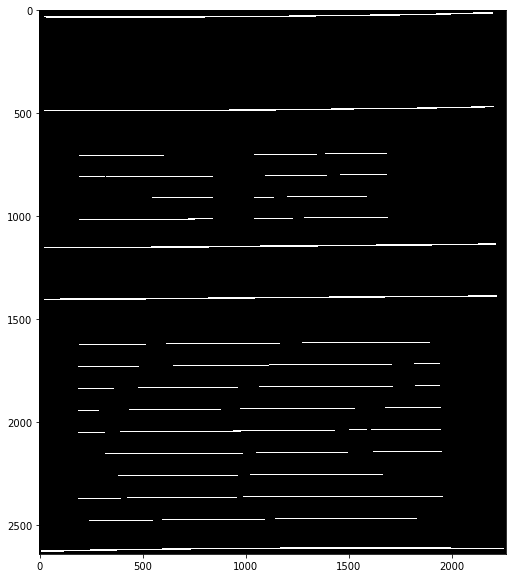

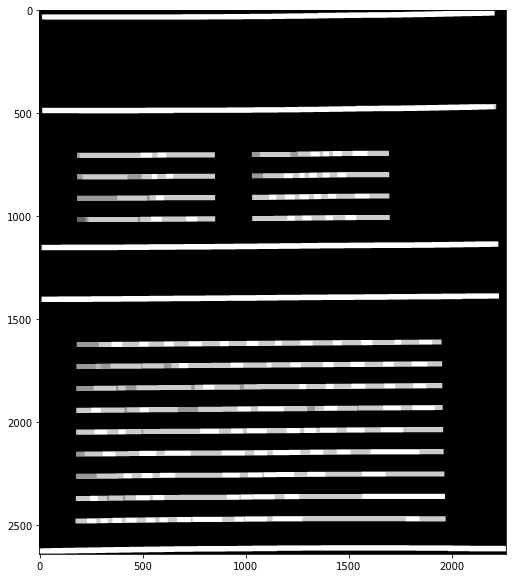

In [8]:
DEBUG = True

def _get_rect(image):
    image = cv2.blur(image, tuple((5, 5)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 21)), (-1, -1))
    imgr = cv2.dilate(image, element, iterations=1)
    if DEBUG:
#             logger.debug('调试，显示处理后合并图')
        plt.imshow(imgr,'gray')
        plt.show()

    nimg, contours, hierarchy = cv2.findContours(imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours
        
imgage = cv2.imread('d:/crop.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)  # 11, 2 这两个参数有什么用 ？？

horizontal = np.copy(img)
vertical = np.copy(img)

cols = horizontal.shape[1]
horizontal_size = int(cols / 30)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)
plt.imshow(horizontal,'gray')
plt.show()
length = imgage.shape[1]
contours = _get_rect(horizontal)

In [24]:
cnts = []
# print(contours)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w > int(length*0.9):
        cnts.append([y,x,h,w])

cnts = np.array(cnts)
idex = np.lexsort([cnts[:, 1], cnts[:, 0]])
cnts = cnts[idex,:]
print(cnts)


[[   0    0   45 2042]
 [ 524   18   44 2026]
 [1046   16   42 2031]
 [1469   22   41 2028]
 [1764   34   41 2020]
 [2059   28   40 2031]
 [2355   39   40 2026]
 [2654   30   39 2038]]


# Y轴相邻排序处理

In [21]:
##### import numpy as np
answers = [[2139, 718, 89, 376], [2145, 294, 89, 379], [2210, 293, 89, 379], [2215, 716, 89, 377], [2295, 291, 90, 380], [2289, 715, 89, 377], [2367, 290, 90, 380], [2364, 714, 89, 378], [2439, 713, 90, 377], [2443, 287, 90, 381]]
print(answers)
answers = np.array(answers)
# print(answers)
ayidx = np.round(np.log10(answers[:,0]/np.std(answers[:,0])),2)
print(ayidx)

# answers = np.insert(answers,4,values=ayidx,axis=1)
# print(answers)

[[2139, 718, 89, 376], [2145, 294, 89, 379], [2210, 293, 89, 379], [2215, 716, 89, 377], [2295, 291, 90, 380], [2289, 715, 89, 377], [2367, 290, 90, 380], [2364, 714, 89, 378], [2439, 713, 90, 377], [2443, 287, 90, 381]]
[1.3  1.31 1.32 1.32 1.33 1.33 1.35 1.35 1.36 1.36]


# 取文字范围

(285, 1735, 3)


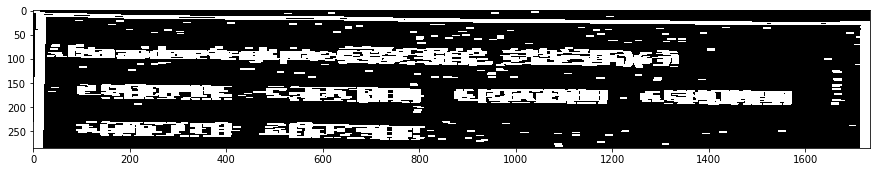

(285, 1735)


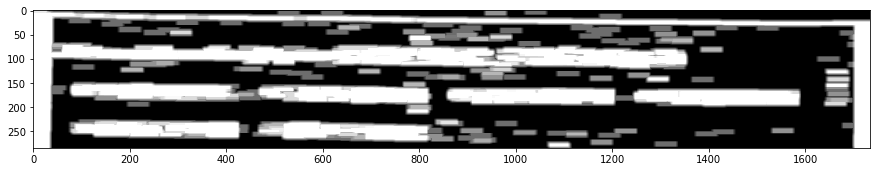

In [77]:
filename = 'd:\\clip_11.jpg'
img = cv2.imread(filename)
print(img.shape)
# img = cv2.imread('d:\\clip_1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(3,3),0)

# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
# img = cv2.blur(img,tuple((5,5)))
# plt.imshow(img,'gray')
# plt.show()

# 去燥点
element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
img = cv2.erode(img, element)



element = cv2.getStructuringElement(cv2.MORPH_RECT, (16,3))
img = cv2.dilate(img, element)


plt.imshow(img,'gray')
plt.show()

# plt.imshow(img,'gray')
# plt.show()

print(img.shape)
img = cv2.blur(img, tuple((7, 7)))
element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((16, 3)), (-1, -1))
img = cv2.dilate(img, element, iterations=2)
plt.imshow(img,'gray')
plt.show()

nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



27
5
allcnts -----------------
[[273, 1066, 12, 52], [270, 1286, 13, 52], [266, 1153, 14, 52], [248, 1360, 32, 88], [238, 995, 34, 332], [250, 1181, 3, 23], [228, 955, 13, 52], [214, 451, 62, 524], [255, 882, 4, 42], [146, 64, 71, 1540], [131, 808, 15, 91], [128, 1230, 23, 93], [125, 1083, 13, 52], [124, 523, 21, 82], [120, 1637, 81, 59], [74, 1381, 14, 53], [51, 1263, 20, 109], [0, 0, 285, 1735], [119, 1187, 3, 5], [58, 832, 21, 172], [49, 1003, 4, 16], [38, 917, 15, 60], [33, 1251, 3, 24], [30, 979, 7, 65], [29, 873, 10, 10], [18, 44, 63, 822], [33, 173, 13, 53]]
select cnts -------------
[[238, 995, 34, 332], [214, 451, 62, 524], [51, 1263, 20, 109], [58, 832, 21, 172], [18, 44, 63, 822]]


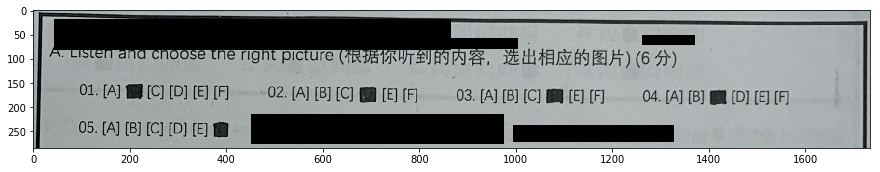

[[  18   44   63  822]
 [  51 1263   20  109]
 [  58  832   21  172]
 [ 214  451   62  524]
 [ 238  995   34  332]]
[0.         0.32327782 0.39185191 1.92007434 2.15518549]
[0, 0, 0, 1, 2]


In [76]:
imgn = cv2.imread(filename)
# imgn = cv2.imread('d:\\clip_1.jpg')
print(len(contours))
cnts = []
allcnts = []
# print(contours)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    allcnts.append([y,x,h,w])
    if w>100 and w < 1000:
        cnts.append([y,x,h,w])
        cv2.rectangle(imgn,(x,y),(x+w,y+h),0,-1)

print(len(cnts))
print('allcnts -----------------')
print(allcnts)
print('select cnts -------------')
print(cnts)
plt.imshow(imgn,'gray')        
plt.show()
# 标准差公式是一种数学公式。标准差也被称为标准偏差，或者实验标准差，公式如下所示：
# 标准差=方差的算术平方根=s=sqrt(((x1-x)^2 +(x2-x)^2 +......(xn-x)^2)/n)
answers = np.array(cnts)
aidx = np.lexsort([answers[:,1],answers[:,0]])
answers = answers[aidx]
print(answers)
zz = (answers[:, 0] - answers[0][0])/ np.std(answers[:, 0],ddof=1)
print(zz)

zz = np.around(zz,1) 

# print(np.log10(zz))

current_cls = 0
clf = [0]

for inx in range(1, len(zz)):
    if abs(zz[inx] - zz[inx-1]) > 0.3:
        current_cls = current_cls + 1
    clf.append(current_cls)
    
print(clf)

# print(np.around(np.around(zz,1),0))
# x,y,w,h = cnts[1]
# crop_img = imgn[y:y+h, x:x+w]

# cv2.imwrite('d:\\clip.jpg',crop_img)
# plt.imshow(crop_img,'gray')        
# plt.show()
# print(cnts)


(264, 1600, 3)


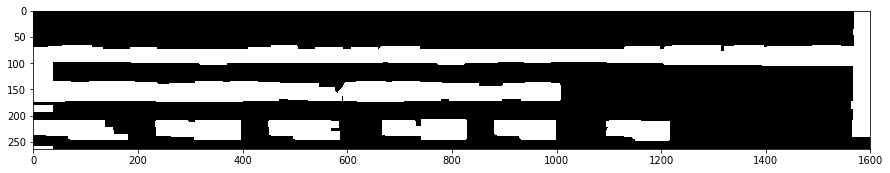

2
1
[[114, 13, 3, 3]]


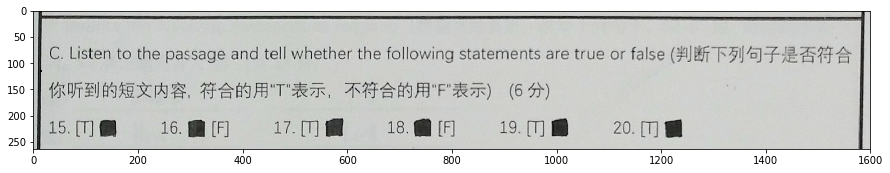

[[114  13   3   3]]
[nan]
[0]


d:\project_tw\anly\venv\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
d:\project_tw\anly\venv\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [58]:
def preprocess(gray):
    # 1. Sobel算子，x方向求梯度
    sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize = 3)
    # 2. 二值化
    ret, binary = cv2.threshold(sobel, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    
    # 3. 膨胀和腐蚀操作的核函数
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 9))
    element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 6))
    
    # 4. 膨胀一次，让轮廓突出
    dilation = cv2.dilate(binary, element2, iterations = 1)
    
    # 5. 腐蚀一次，去掉细节，如表格线等。注意这里去掉的是竖直的线
    erosion = cv2.erode(dilation, element1, iterations = 1)
    
    # 6. 再次膨胀，让轮廓明显一些
    dilation2 = cv2.dilate(erosion, element2, iterations = 2)
    
    plt.imshow(dilation2,'gray')
    plt.show()

filename = 'd:\\clip_10.jpg'
img = cv2.imread(filename)
print(img.shape)
# img = cv2.imread('d:\\clip_1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
preprocess(img)

nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

imgn = cv2.imread(filename)
# imgn = cv2.imread('d:\\clip_1.jpg')
print(len(contours))
cnts = []
# print(contours)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w < 1000:
        cnts.append([y,x,h,w])
        cv2.rectangle(imgn,(x,y),(x+w,y+h),0,-1)

print(len(cnts))
print(cnts)
plt.imshow(imgn,'gray')        
plt.show()
# 标准差公式是一种数学公式。标准差也被称为标准偏差，或者实验标准差，公式如下所示：
# 标准差=方差的算术平方根=s=sqrt(((x1-x)^2 +(x2-x)^2 +......(xn-x)^2)/n)
answers = np.array(cnts)
aidx = np.lexsort([answers[:,1],answers[:,0]])
answers = answers[aidx]
print(answers)
zz = (answers[:, 0] - answers[0][0])/ np.std(answers[:, 0],ddof=1)
print(zz)

zz = np.around(zz,1) 

# print(np.log10(zz))

current_cls = 0
clf = [0]

for inx in range(1, len(zz)):
    if abs(zz[inx] - zz[inx-1]) > 0.3:
        current_cls = current_cls + 1
    clf.append(current_cls)
    
print(clf)




# 取单个文字范围

(49, 171, 3)


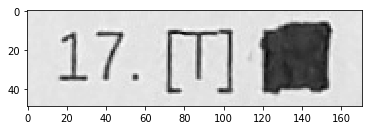

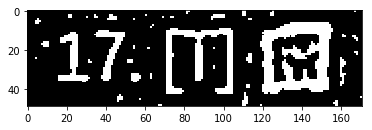

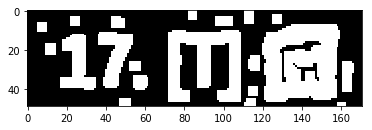

0.6206896551724138
0.6206896551724138
1.0
1.0
0.12494349479675293
[[12, 17, 29, 18], [11, 36, 29, 18], [10, 72, 37, 37], [7, 120, 40, 40]]


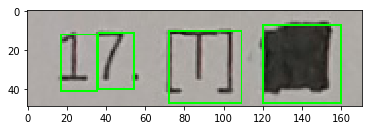

In [8]:
# img = cv2.imread('d:\\clip.jpg')
# 360n4s_10_AB-D iphone8P_100_-BCDE
def check_in_areas(rect, rect_lists):
    in_area = False
    y,x,h,w = rect
    for item in rect_lists:
        iy,ix,ih,iw = item
        if y>iy and x>ix and (y+h) < (iy + ih) and (x+w) <  (ix + iw):
            in_area = True
    return in_area

# with open('D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\360n4s_10_AB-D.jpg','rb') as ff:
path = 'D:\\PROJECT_TW\\git\\data\example\\image\\clip\\小米5_17_T-.jpg'
with open(path,'rb') as ff:
    imgbin = ff.read()
    
imgbin = np.frombuffer(imgbin, np.uint8)    
# img = cv2.imread('D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\iphoneXS_28_AB-D.jpg')
img = cv2.imdecode(imgbin,cv2.IMREAD_COLOR)
print(img.shape)
imgn = img.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,'gray')
plt.show()
img = cv2.GaussianBlur(img,(3,3),0)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
plt.imshow(img,'gray')
plt.show()

start_time = time.time()

# 去燥点
element = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
img = cv2.erode(img, element)
img = cv2.dilate(img, element,iterations=4)
plt.imshow(img,'gray')
plt.show()


nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = []
for cnt in contours:
    if cv2.contourArea(cnt) > 200:    
        rect = cv2.boundingRect(cnt)
        x,y,w,h = rect
        # 检查新增的区域是否在现有区域里面
        if w/h>0.35:
            print(w/h)
            nrect = [y,x,h,w]
            if not check_in_areas(nrect, cnts):
                cnts.append([y,x,h,w])
                cv2.rectangle(imgn,(x,y),(x+w,y+h),(0,255,0),1)

        
print(time.time() - start_time)        
print(cnts)
plt.imshow(imgn,'brg')
plt.show()


(32, 32, 3)


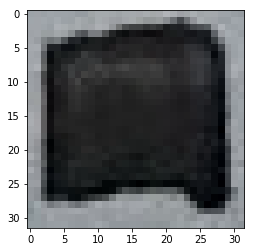

In [11]:
img = cv2.imread('d:\\clip.jpg')
x,y,w,h = cnts[4]
black_img = img[y:y+h, x:x+w]
# black_img = cv2.cvtColor(black_img,cv2.COLOR_BGR2GRAY)
# h,w = black_img.shape
black_img = cv2.resize(black_img, (32, 32), interpolation=cv2.INTER_CUBIC)
print(black_img.shape)
cv2.imwrite('d:\\1_0.jpg',black_img)
plt.imshow(black_img,'gray')
plt.show()
# print(black_img.shape)

# 取单个文字范围二

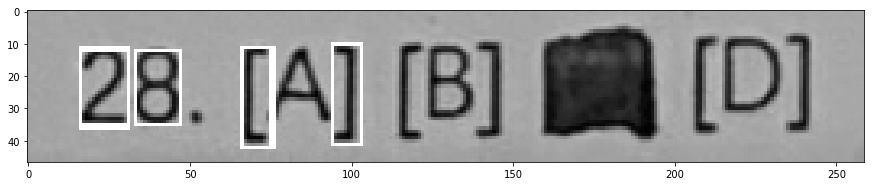

[[66 11  9 31]
 [66 11  9 31]
 [66 11 10 31]
 [94 10  9 31]
 [16 12 15 23]
 [16 12 15 23]
 [16 11 15 25]
 [16 11 15 25]
 [16 11 15 25]
 [33 12 14 23]]


In [16]:
# https://www.cnblogs.com/jkmiao/p/6797252.html
with open('D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\iphoneXS_28_AB-D.jpg','rb') as ff:
    imgbin = ff.read()
    
imgbin = np.frombuffer(imgbin, np.uint8)    
# img = cv2.imread('D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\小米5_94_--CDE.jpg')
img = cv2.imdecode(imgbin,cv2.IMREAD_COLOR)
imgn = img.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
mser = cv2.MSER_create(_min_area=150)
regions, boxes = mser.detectRegions(img)
boxes = boxes[0:10]
for box in boxes:
    x, y, w, h = box
    cv2.rectangle(img, (x,y),(x+w, y+h), (255, 0, 0), 1)
    
plt.imshow(img,'gray')    
plt.show()

print(boxes)